In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import maketab as mt

In [2]:
'''
def norm(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def data(l):
    t = np.arange(l)
    x = 0.3*np.sin(t/5)
    x += (-1)*np.exp(t/l)
    x += np.random.normal(0, 0.1, l)
    return np.array(norm(x))
'''

'\ndef norm(data):\n    min_val = np.min(data)\n    max_val = np.max(data)\n    scaled_data = (data - min_val) / (max_val - min_val)\n    return scaled_data\n\ndef data(l):\n    t = np.arange(l)\n    x = 0.3*np.sin(t/5)\n    x += (-1)*np.exp(t/l)\n    x += np.random.normal(0, 0.1, l)\n    return np.array(norm(x))\n'

In [3]:
norm_upper = 4
norm_lower = 2
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    signal = signal[50:]
    return signal

def load_data(path_dir='data/5-2-25/'):
    t, signal = mt.battery(path_dir)
    return norm(signal)[:1000]

In [4]:
class CreateDataset(Dataset):
    def __init__(self, data, n, m):
        self.data = data
        self.n = n  # Sequence length
        self.m = m  # Prediction length
        self.total_length = len(self.data)

    def __len__(self):
        return self.total_length - self.n - self.m + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.n]
        y = self.data[idx + self.n:idx + self.n + self.m]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        return x, y

In [5]:
'''
class AutoregressivePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predicts only 1 step

    def forward(self, x, pred_steps=1):
        outputs = []
        for _ in range(pred_steps):
            out, _ = self.lstm(x)
            pred = self.fc(out[:, -1, :])  # Take last step
            outputs.append(pred)
            x = torch.cat([x[:, 1:, :], pred.unsqueeze(1)], dim=1)  # Slide window
        return torch.cat(outputs, dim=1)
'''
#'''
class AutoregressivePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predicts only 1 step

    def forward(self, x, pred_steps=1):
        outputs = []
        for _ in range(pred_steps):
            out, _ = self.rnn(x)
            pred = self.fc(out[:, -1, :])  # Take last step
            outputs.append(pred)
            x = torch.cat([x[:, 1:, :], pred.unsqueeze(1)], dim=1)  # Slide window
        return torch.cat(outputs, dim=1)
#'''

In [6]:
def train_model(model, dataloader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            
            # Train with teacher forcing (predict pred_len steps)
            outputs = model(batch_x, pred_steps=pred_len)
            
            loss = criterion(outputs, batch_y.squeeze(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')
        losses.append(avg_loss)   
    return model

In [7]:
# Hyperparameters
seq_len = 20  # Input sequence length
pred_len = 20  # Prediction length during training
hidden_size = 64
num_layers = 2
batch_size = 16
epochs = 50
learning_rate = 0.001

# Generate and normalize data
#data_length = 500
#ts_data = data(data_length)  # Your synthetic time series
#t = np.arange(data_length)   # Time axis for plotting
ts_data = load_data()

# Create dataset and dataloader
dataset = CreateDataset(ts_data, seq_len, pred_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss and optimizer
model = AutoregressivePredictor(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(model, dataloader, epochs)

Epoch 0, Loss: 0.051955
Epoch 10, Loss: 0.000675
Epoch 20, Loss: 0.000703
Epoch 30, Loss: 0.000634
Epoch 40, Loss: 0.000693


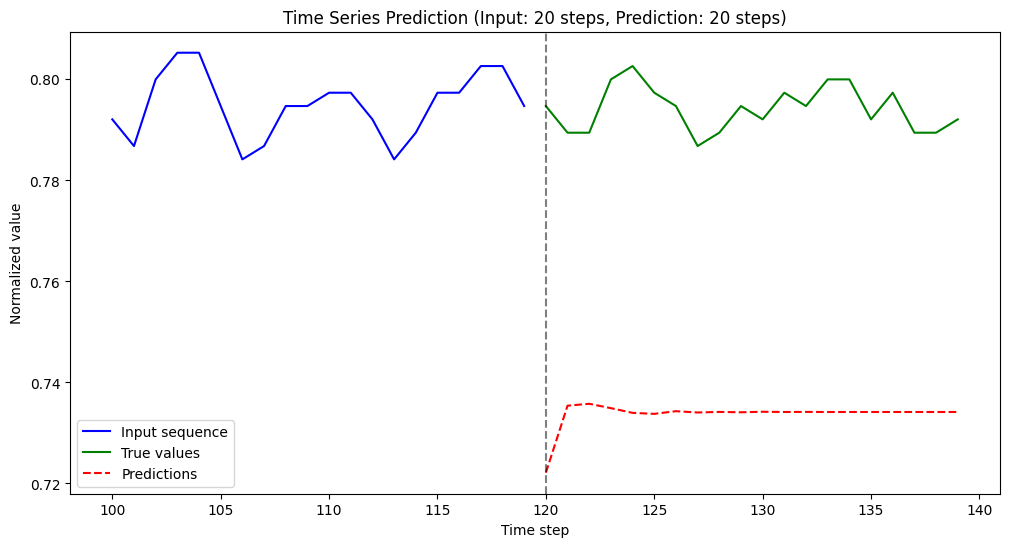

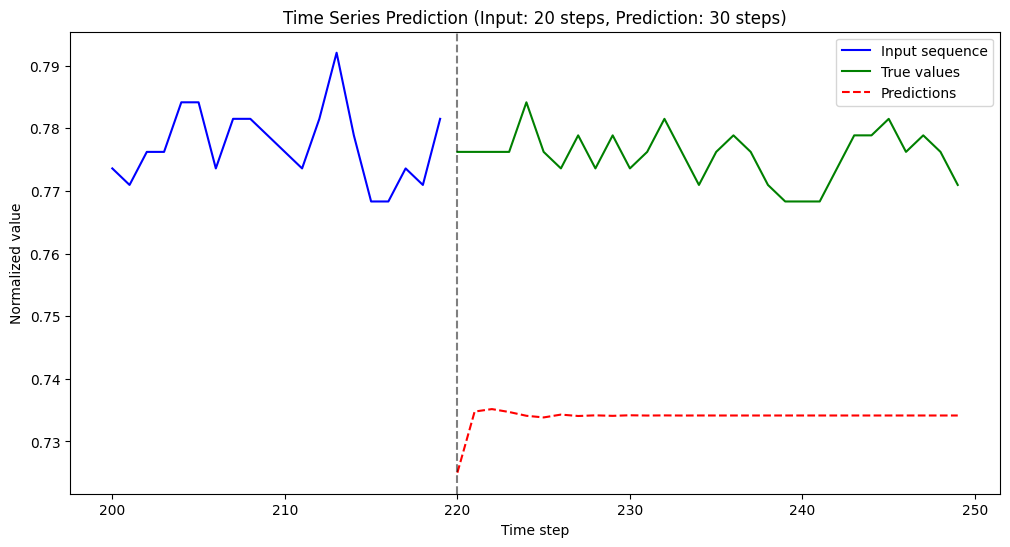

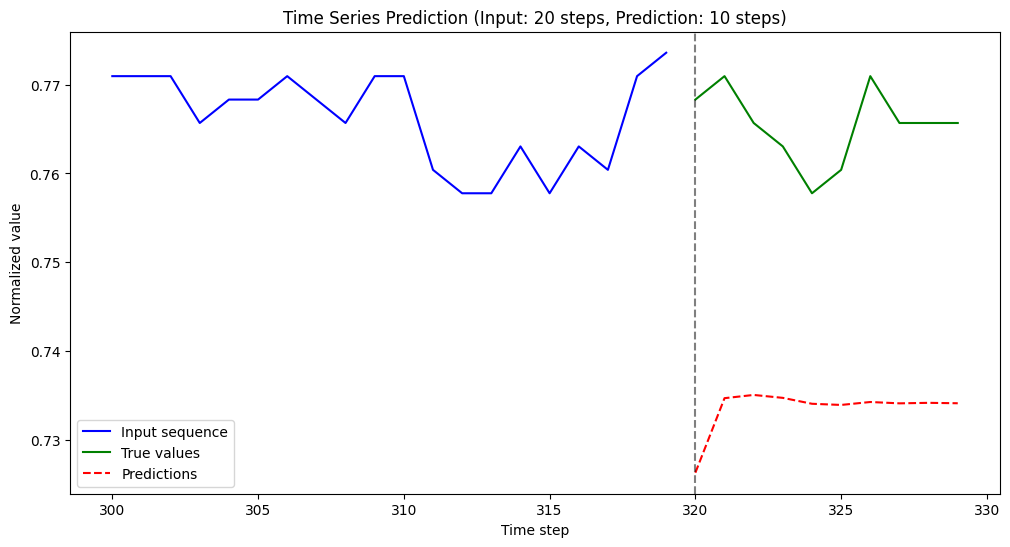

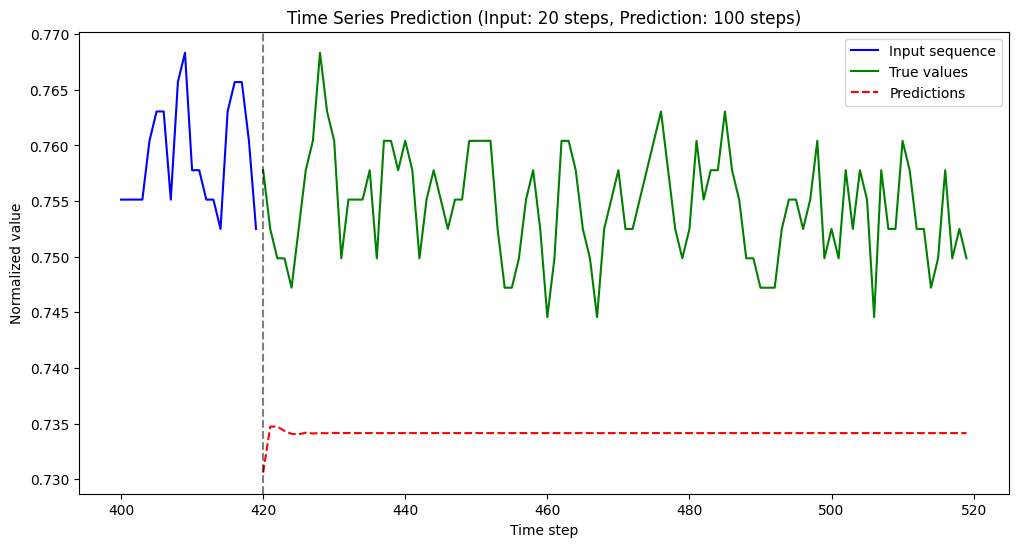

In [8]:
def evaluate_model(model, data, seq_len, eval_pred_len=20, start_idx=0):
    model.eval()
    t = np.arange(len(data))
    
    # Select a test sequence
    test_input = torch.tensor(data[start_idx:start_idx+seq_len], 
                            dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    
    # Make predictions autoregressively
    with torch.no_grad():
        predictions = model(test_input, pred_steps=eval_pred_len).numpy().flatten()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Plot history (input sequence)
    plt.plot(t[start_idx:start_idx+seq_len], 
             data[start_idx:start_idx+seq_len], 
             'b-', label='Input sequence')
    
    # Plot true future values
    plt.plot(t[start_idx+seq_len:start_idx+seq_len+eval_pred_len], 
             data[start_idx+seq_len:start_idx+seq_len+eval_pred_len], 
             'g-', label='True values')
    
    # Plot predictions
    plt.plot(t[start_idx+seq_len:start_idx+seq_len+eval_pred_len], 
             predictions, 
             'r--', label='Predictions')
    
    plt.axvline(x=start_idx+seq_len, color='k', linestyle='--', alpha=0.5)
    plt.title(f'Time Series Prediction (Input: {seq_len} steps, Prediction: {eval_pred_len} steps)')
    plt.xlabel('Time step')
    plt.ylabel('Normalized value')
    plt.legend()
    plt.show()

# Evaluate with different prediction lengths
evaluate_model(model, ts_data, seq_len, eval_pred_len=20, start_idx=100)
evaluate_model(model, ts_data, seq_len, eval_pred_len=30, start_idx=200)  # Longer prediction
evaluate_model(model, ts_data, seq_len, eval_pred_len=10, start_idx=300)  # Shorter prediction
evaluate_model(model, ts_data, seq_len, eval_pred_len=100, start_idx=400)  # Shorter prediction